In [6]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.definitions import compute
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = jet_position_as_da(all_jets_one_df)
# props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

In [40]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/4"))

net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

100%|██████████| 24/24 [19:10<00:00, 47.93s/it]


In [48]:
ds_center = ds_center.load()
df_center = pl.from_pandas(ds_center.to_dataframe().reset_index())
centers_all_jets = find_all_jets(df_center, base_s_thresh=20, alignment_thresh=0.5)
centers_all_jets = is_polar_gmix(centers_all_jets, ("lon", "lat", "theta"), n_components=2, n_init=20)

centers_props_uncat = compute_jet_props(centers_all_jets)
centers_props = categorize_df_jets(centers_props_uncat, polar_cutoff=0.01)

100%|██████████| 24/24 [00:00<00:00, 572.88it/s]


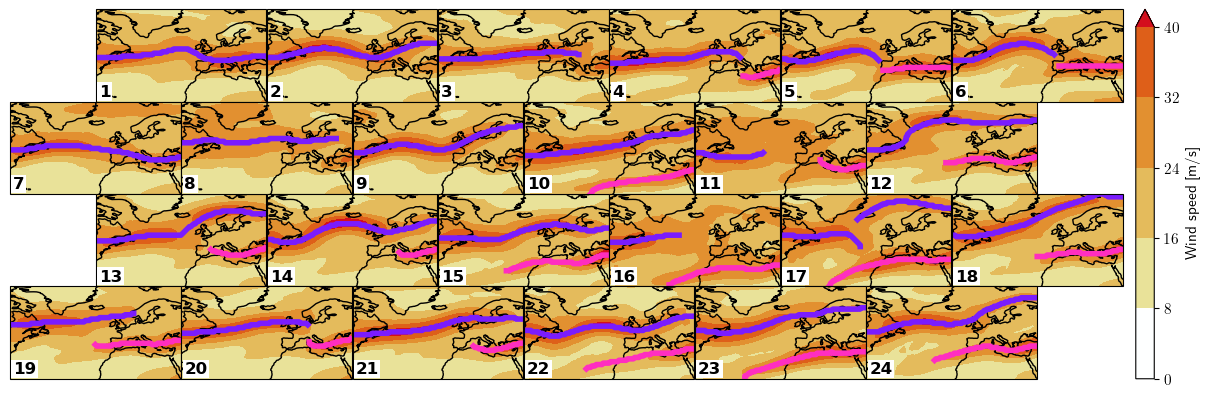

In [49]:
clu = Clusterplot(net.y, net.x, get_region(da), honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    # transparify=1,
    levels=[0, 8, 16, 24, 32, 40],
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01}
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.35
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy()[1:].T, lw=4, color=color)
clu.resize_relative([0.95, 1])
plt.savefig(f'{FIGURES}/som_composites/wind_and_jets.png')

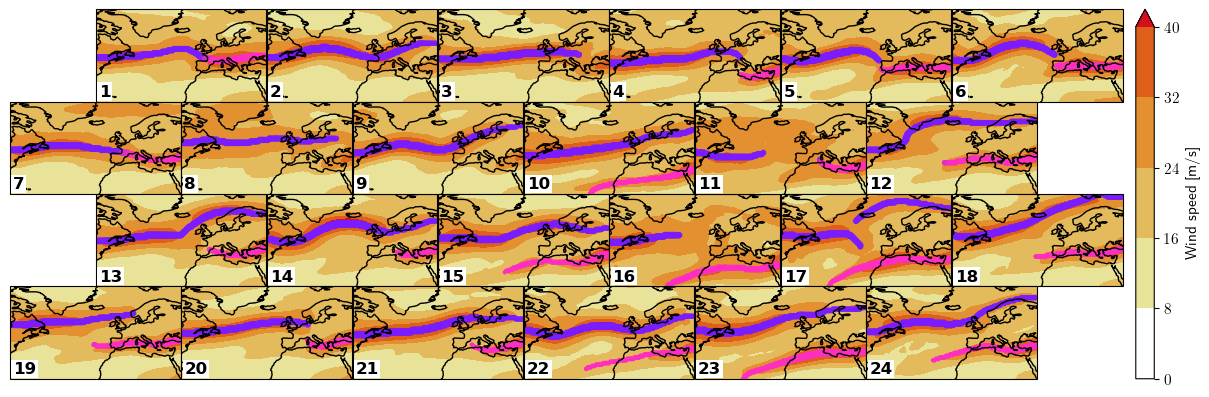

In [50]:
clu = Clusterplot(net.y, net.x, get_region(da), honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    # transparify=1,
    levels=[0, 8, 16, 24, 32, 40],
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01}
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    # is_polar = jet["is_polar"].mean() >= 0.35
    # color = COLORS[2 - int(is_polar)]
    ax.scatter(*jet[["lon", "lat"]].to_numpy().T, c=jet["is_polar"], s=jet["s"] - 15, cmap=PINKPURPLE, vmin=0, vmax=1)
clu.resize_relative([0.95, 1])
plt.savefig(f'{FIGURES}/som_composites/wind_and_jets_scatter.png')

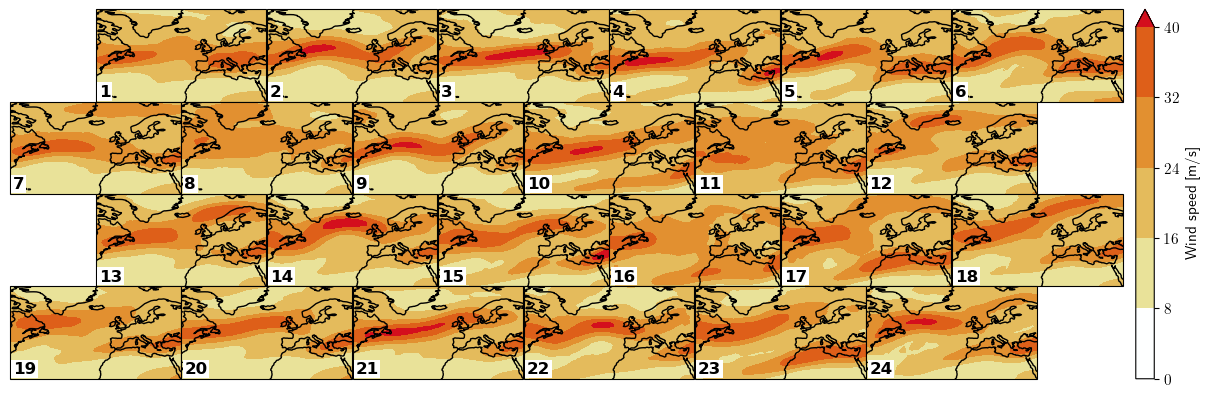

In [51]:
clu = Clusterplot(net.y, net.x, get_region(da), honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    # transparify=1,
    levels=[0, 8, 16, 24, 32, 40],
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01}
)
clu.resize_relative([0.95, 1])
plt.savefig(f'{FIGURES}/som_composites/wind.png')

In [49]:
dh_T = DataHandler.from_specs(
    "ERA5", "surf", "t", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_T = compute(dh_T.da, progress=True)

100%|██████████| 24/24 [00:00<00:00, 38.26it/s]


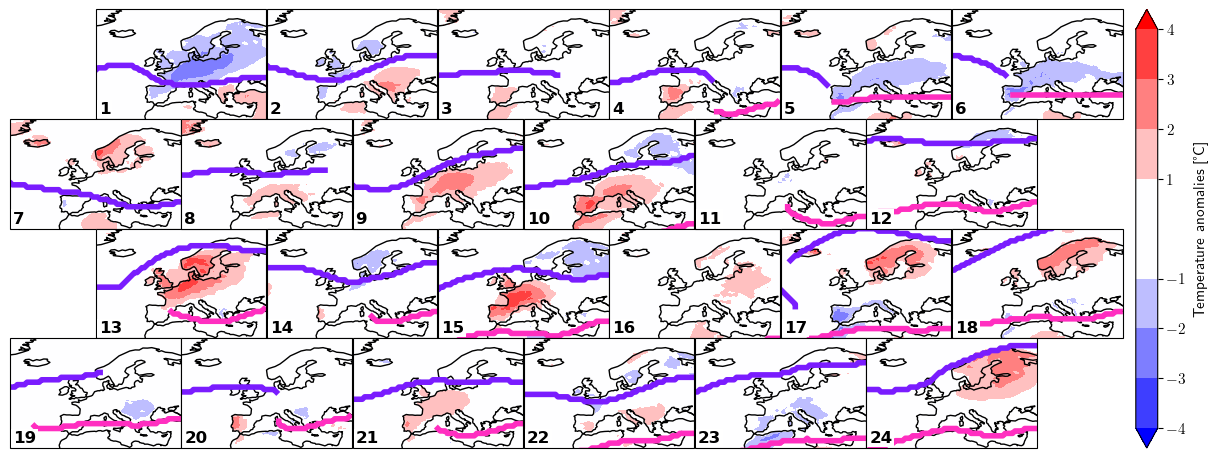

In [50]:
clu = Clusterplot(net.y, net.x, get_region(da_T), honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_T, mask, "contourf", levels=7, stippling=False, cbar_label="Temperature anomalies [°C]", cbar_kwargs=dict(pad=0.01), cmap='bwr', q=0.999
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.35
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy()[1:].T, lw=4, color=color)
clu.resize_relative([0.95, 1])
plt.savefig(f'{FIGURES}/som_composites/temp.png')

In [51]:
dh_tp = DataHandler.from_specs(
    "ERA5", "surf", "tp", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_tp = compute(dh_tp.da, progress=True)

100%|██████████| 24/24 [00:01<00:00, 21.91it/s]


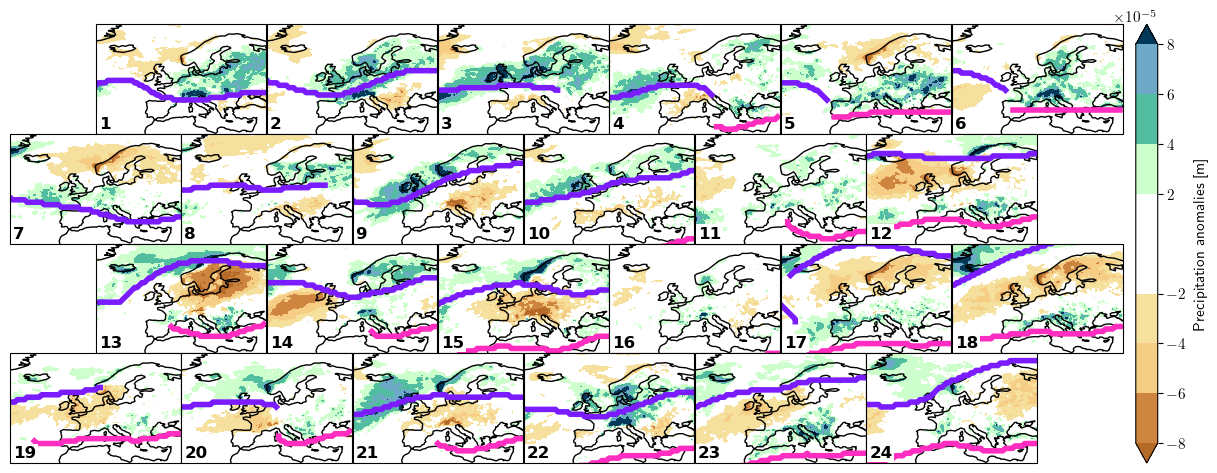

In [52]:
clu = Clusterplot(net.y, net.x, get_region(da_tp), honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_tp, mask, "contourf", levels=7, stippling=False, cbar_label="Precipitation anomalies [m]", cbar_kwargs=dict(pad=0.01), cmap=colormaps.precip_diff_12lev, q=0.99
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.35
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy()[1:].T, lw=4, color=color)
clu.resize_relative([0.95, 1])
plt.savefig(f'{FIGURES}/som_composites/prec.png')

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "apvs", "6H", "dayofyear", {"dayofyear": ("win", 15)})

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "cpvs", "6H", "dayofyear", {"dayofyear": ("win", 15)})

In [ ]:
da_pvs = DataHandler.from_specs("ERA5", "thetalev", "apvs", "6H", "all", "JJA", *get_region(da), 250, "dayofyear", {"dayofyear": ("win", 15)}).da
da_pvs = compute(da_pvs, progress=True)

100%|██████████| 24/24 [00:01<00:00, 14.20it/s]


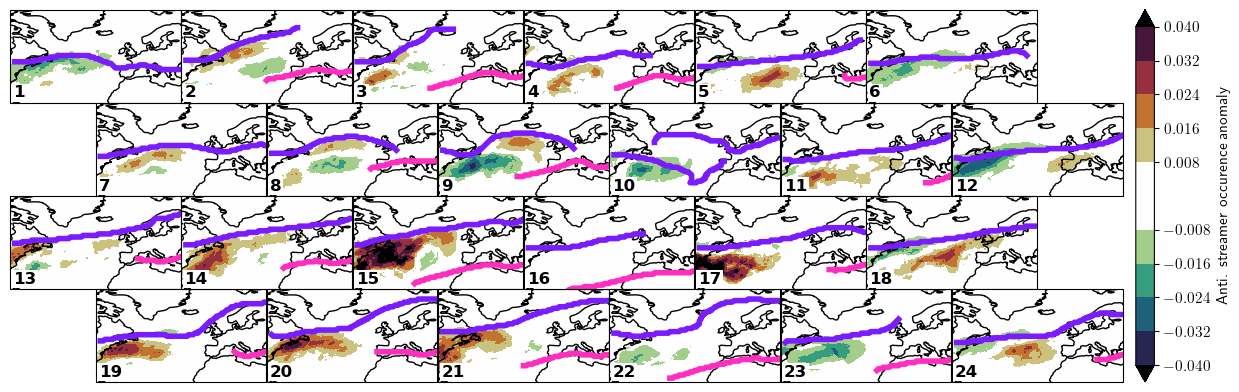

In [52]:
clu = Clusterplot(net.y, net.x, get_region(da_pvs), honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_pvs.loc[:, 'anti'], mask, "contourf", levels=11, stippling=False, cbar_label="Anti. streamer occurence anomaly", cbar_kwargs=dict(pad=0.01), cmap=colormaps.seasons, q=0.998
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.5
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy()[1:].T, lw=4, color=color)
clu.resize_relative([0.95, 1])
plt.savefig(f'{FIGURES}/som_composites/apvs.png')

100%|██████████| 24/24 [00:01<00:00, 14.23it/s]


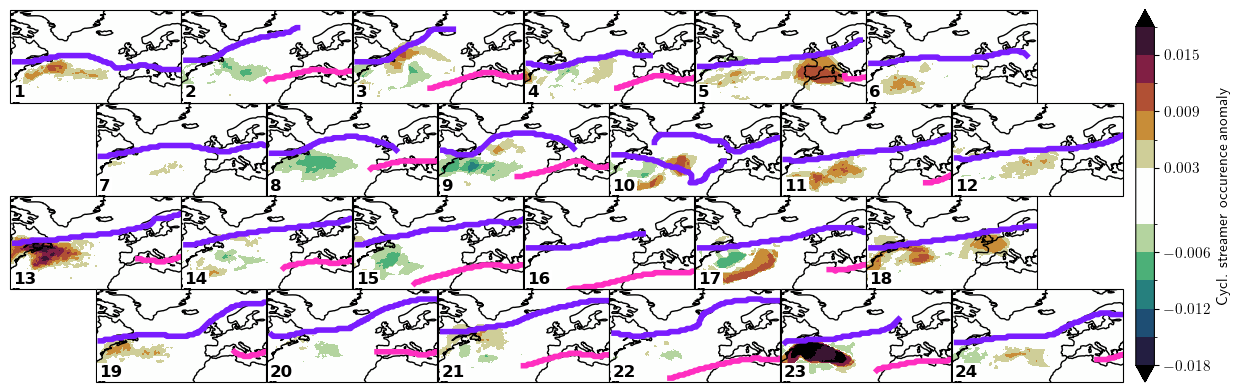

In [53]:
clu = Clusterplot(net.y, net.x, get_region(da_pvs), honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_pvs.loc[:, 'cycl'], mask, "contourf", levels=11, stippling=False, cbar_label="Cycl. streamer occurence anomaly", cbar_kwargs=dict(pad=0.01), cmap=colormaps.seasons, q=0.998
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.5
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy()[1:].T, lw=4, color=color)
clu.resize_relative([0.95, 1])
plt.savefig(f'{FIGURES}/som_composites/cycl.png')

100%|██████████| 24/24 [00:00<00:00, 297.59it/s]


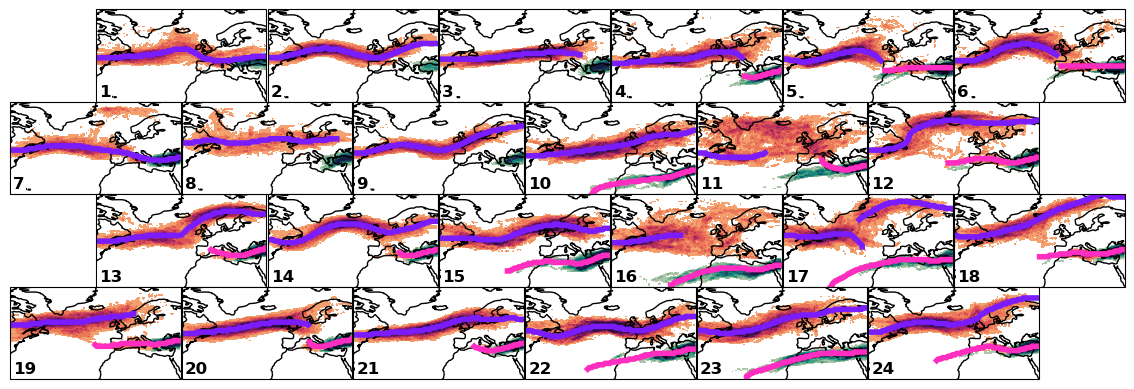

In [11]:
clu = Clusterplot(net.y, net.x, get_region(jet_pos_da), honeycomb=True, numbering=True)
jet_pos_da_summer = jet_pos_da.sel(time=jet_pos_da.time.dt.season=="JJA")
stj_da = jet_pos_da_summer < 0.1
edj_da = jet_pos_da_summer > 0.9
for ax in clu.axes:
    ax.autoscale(False)
_ = clu.add_any_contour_from_mask(
    stj_da, mask, cbar_label="Subtropical jet occurence", transparify=2, levels=9, cmap=colormaps.tempo, draw_cbar=False,
)
_ = clu.add_any_contour_from_mask(
    edj_da, mask, cbar_label="Polar jet occurence", transparify=2, levels=9, cmap=colormaps.matter, draw_cbar=False,
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.5
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy()[1:].T, lw=4, color=color)

clu.resize_relative([0.8, 1])
clu.fig.savefig(f'{FIGURES}/som_composites/jet_pos.png')

In [16]:
dh_z = DataHandler.from_specs(
    "ERA5", "plev", "z", "6H", "all", "JJA", -80, 40, 15, 80, 500, 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_z = compute(dh_z.da, progress=True)

[########################################] | 100% Completed | 179.46 s


100%|██████████| 24/24 [00:02<00:00,  9.52it/s]


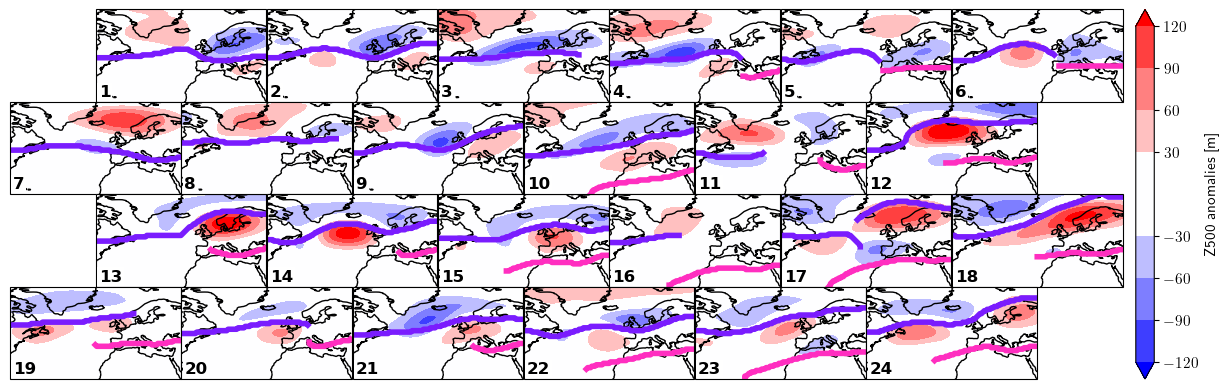

In [17]:
import scipy.constants as co
da_z = da_z / co.g
clu = Clusterplot(net.y, net.x, get_region(da_z), honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_z, mask, "contourf", stippling=False, cbar_label="Z500 anomalies [m]", cmap='bwr', q=0.993, levels=7, cbar_kwargs=dict(pad=0.01)
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.5
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy()[1:].T, lw=4, color=color)
clu.resize_relative([0.95, 1])
plt.savefig(f'{FIGURES}/som_composites/z500.png')